<a href="https://colab.research.google.com/github/mkane968/Text-Mining-with-Student-Papers/blob/main/Text_Mining_Student_Essays_A_Computational_Exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text Mining Student Essays: A Computational Exploration

This pipeline will ingest, clean and analyze meaningful language patterns in a corpora of student papers. The following input is required: 

*   Corpus of student papers (.txt files)
*   Grades and other relevant metadata associated with the papers (.csv files)


## 1. Install Packages

In [ ]:
#Mount Google Drive
from google.colab import drive
from google.colab import files

#Install glob
import glob 

#Install pandas
import pandas as pd

#Install numpy
import numpy as np

#Imports the Natural Language Toolkit, which is necessary to install NLTK packages and libraries
#!pip install nltk
import nltk

#Installs libraries and packages to tokenize text
nltk.download('punkt')
from nltk.tokenize import sent_tokenize, word_tokenize
from  nltk.text import ConcordanceIndex

#Installs libraries and packages to clean text
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer

#Import matplotlib for visualizations
import matplotlib.pyplot as plt


import re  # For preprocessing
from time import time  # To time our operations
from collections import defaultdict  # For word frequency
import logging  # Setting up the loggings to monitor gensim

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## 2. Import Student Essays and Metadata

###Import Student Essays and Add to DataFrame

In [ ]:
#Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Add files to upload from local machine
uploaded = files.upload()

Saving achesonalessandro_193606_13858036_Final Portfolio Eng 802 - Acheson .txt to achesonalessandro_193606_13858036_Final Portfolio Eng 802 - Acheson .txt
Saving ahenkoraravenmanu_LATE_232002_18873129_English 0802 Portfolio - Raven Ahenkora.txt to ahenkoraravenmanu_LATE_232002_18873129_English 0802 Portfolio - Raven Ahenkora.txt
Saving bedellolivia_195145_16640649_Analytical Reading and Writing Final Portfolio.txt to bedellolivia_195145_16640649_Analytical Reading and Writing Final Portfolio.txt
Saving benjamincamillia_193400_11506010_Camillia Benjamin Final Portfolio.txt to benjamincamillia_193400_11506010_Camillia Benjamin Final Portfolio.txt
Saving bernsteingage_LATE_227638_18903293_Final Portfolio- English 0802.txt to bernsteingage_LATE_227638_18903293_Final Portfolio- English 0802.txt
Saving bortolottiryan_LATE_232933_18872422_Portfolio.txt to bortolottiryan_LATE_232933_18872422_Portfolio.txt
Saving braunsteinaydan_232993_19273434_Final Portfolio.txt to braunsteinaydan_232993_192

In [ ]:
#Put essays into dataframe
essays = pd.DataFrame.from_dict(uploaded, orient='index')

#Reset index and add column names to make wrangling easier
essays = essays.reset_index()
essays.columns = ["ID", "Text"]

#Remove encoding characters from Text column (b'\xef\xbb\xbf)
essays['Text'] = essays['Text'].apply(lambda x: x.decode('utf-8'))

#Remove newline characters and put in new column 
essays['Text_Newlines'] = essays['Text']
essays['Text'] = essays['Text'].str.replace(r'\s+|\\r', ' ', regex=True) 
essays['Text'] = essays['Text'].str.replace(r'\s+|\\n', ' ', regex=True) 
essays.head()

,ID,Text,Text_Newlines
0,achesonalessandro_193606_13858036_Final Portfo...,"I have learned a lot through English 802, mor...","\tI have learned a lot through English 802, mo..."
1,ahenkoraravenmanu_LATE_232002_18873129_English...,Raven Ahenkora Professor Megan Kane English 08...,Raven Ahenkora\nProfessor Megan Kane\nEnglish ...
2,bedellolivia_195145_16640649_Analytical Readin...,Olivia Bedell Professor Megan Kane ENG 802 14 ...,Olivia Bedell\nProfessor Megan Kane\nENG 802\n...
3,benjamincamillia_193400_11506010_Camillia Benj...,Camillia Benjamin Prof. Kane English 802 06 De...,Camillia Benjamin\nProf. Kane\nEnglish 802\n06...
4,bernsteingage_LATE_227638_18903293_Final Portf...,Bernstein 1 Gage Bernstein English 0802 Profes...,Bernstein 1\nGage Bernstein\nEnglish 0802\nPro...


### Remove identifying information from each paper ID (instructor/student names) 

In [ ]:
#Remove identifying information from ID
#Remove any occurences of "LATE_" from dataset (otherwise will skew ID cleaning)
essays['ID'] = essays['ID'].str.replace(r'LATE_', '', regex=True) 

#Split book on first underscore (_) in ID, keep only text in between first and second underscore (ID number)
start = essays["ID"].str.split("_", expand = True)
essays['ID'] = start[1]
essays['ID'] = essays['ID'].astype(int)
essays

,ID,Text,Text_Newlines
0,193606,"I have learned a lot through English 802, mor...","\tI have learned a lot through English 802, mo..."
1,232002,Raven Ahenkora Professor Megan Kane English 08...,Raven Ahenkora\nProfessor Megan Kane\nEnglish ...
2,195145,Olivia Bedell Professor Megan Kane ENG 802 14 ...,Olivia Bedell\nProfessor Megan Kane\nENG 802\n...
3,193400,Camillia Benjamin Prof. Kane English 802 06 De...,Camillia Benjamin\nProf. Kane\nEnglish 802\n06...
4,227638,Bernstein 1 Gage Bernstein English 0802 Profes...,Bernstein 1\nGage Bernstein\nEnglish 0802\nPro...
...,...,...,...
99,189740,Isabella Volpe Professor Kane ENG 802 21 April...,Isabella Volpe\nProfessor Kane\nENG 802\n21 Ap...
100,186629,Amaya Whipple Professor Megan Kane ENG 802 9 F...,Amaya Whipple\nProfessor Megan Kane\nENG 802\n...
101,185528,Ashrita Yellani Professor Kane English 0802 De...,Ashrita Yellani\nProfessor Kane\nEnglish 0802\...
102,189403,Yuknek 1 Kathryn Yuknek Professor Kane ENG 802...,Yuknek 1\n\n\nKathryn Yuknek\n\n\nProfessor Ka...


In [ ]:
len(essays)

104

### Import grades and additional metadata to second dataframe


In [ ]:
#Upload csvs with essay metadata
uploaded_grades = files.upload()

Saving 2022-09-13T0943_Grades-LA-ENG-0802-711-10742-202220.csv to 2022-09-13T0943_Grades-LA-ENG-0802-711-10742-202220.csv
Saving 2022-09-13T0945_Grades-LA-ENG-0802-062-37264-202203.csv to 2022-09-13T0945_Grades-LA-ENG-0802-062-37264-202203.csv
Saving 2022-11-28T1326_Grades-LA-ENG-0802-011-4684-202103.csv to 2022-11-28T1326_Grades-LA-ENG-0802-011-4684-202103.csv
Saving 2022-11-28T1331_Grades-LA-ENG-0802-012-3352-202136.csv to 2022-11-28T1331_Grades-LA-ENG-0802-012-3352-202136.csv
Saving 2022-11-28T1332_Grades-LA-ENG-0802-010-3350-202036.csv to 2022-11-28T1332_Grades-LA-ENG-0802-010-3350-202036.csv


In [ ]:
#Link to path where csv files are stored in drive
local_path = r'/content'

#Create variable to store all csvs in path
filenames = glob.glob(local_path + "/*.csv")

#Create df list for all csvs
dfs = [pd.read_csv(filename) for filename in filenames]

len(filenames)

5

In [ ]:
print(filenames)

['/content/2022-09-13T0943_Grades-LA-ENG-0802-711-10742-202220.csv', '/content/2022-11-28T1332_Grades-LA-ENG-0802-010-3350-202036.csv', '/content/2022-09-13T0945_Grades-LA-ENG-0802-062-37264-202203.csv', '/content/2022-11-28T1331_Grades-LA-ENG-0802-012-3352-202136.csv', '/content/2022-11-28T1326_Grades-LA-ENG-0802-011-4684-202103.csv']


In [ ]:
# Concatenate all data into one DataFrame
metadata = pd.concat(dfs, ignore_index=True)

#Change data to string (for further cleaning)
metadata.astype(str)

metadata

,Student,ID,SIS User ID,SIS Login ID,Integration ID,Section,Final Portfolio (1689777),Weekly Assignments Current Score,Weekly Assignments Unposted Current Score,Weekly Assignments Final Score,...,Assignments Unposted Final Score,Quizzes Current Score,Quizzes Unposted Current Score,Quizzes Final Score,Quizzes Unposted Final Score,Discussions Current Score,Discussions Unposted Current Score,Discussions Final Score,Discussions Unposted Final Score,Final Portfolio (1059452)
0,Points Possible,NaN,NaN,NaN,NaN,NaN,100.0,(read only),(read only),(read only),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"Braunstein, Aydan",232993.0,tun93646,tun93646,915967676.0,Section: 711,94.0,100.09,100.09,100.09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"Clancy, Hannah",232214.0,tuo91570,tuo91570,916062331.0,Section: 711,92.0,100.26,100.26,100.26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"Cuascut-Palmer, Corey",237430.0,tuo77740,tuo77740,916050168.0,Section: 711,85.0,97.44,97.44,97.44,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,"Duckworth, Emily",227040.0,tuo35762,tuo35762,916008595.0,Section: 711,95.0,100.26,100.26,100.26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120,"Smith, Angel K",193777.0,NaN,tun47957,NaN,Section: 011,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.00,89.0
121,"Volpe, Isabella",189740.0,NaN,tun36899,NaN,Section: 011,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.00,89.0
122,"Whipple, Amaya",186629.0,NaN,tun31456,NaN,Section: 011,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.00,86.0
123,"Yuknek, Kathryn",189403.0,NaN,tun30777,NaN,Section: 011,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.00,84.0


In [ ]:
#Drop header rows(Points Possible) and test student rows (Student, Test)
metadata = metadata[metadata['Student'].str.contains('Points Possible|Student, Test')==False]
metadata

,Student,ID,SIS User ID,SIS Login ID,Integration ID,Section,Final Portfolio (1689777),Weekly Assignments Current Score,Weekly Assignments Unposted Current Score,Weekly Assignments Final Score,...,Assignments Unposted Final Score,Quizzes Current Score,Quizzes Unposted Current Score,Quizzes Final Score,Quizzes Unposted Final Score,Discussions Current Score,Discussions Unposted Current Score,Discussions Final Score,Discussions Unposted Final Score,Final Portfolio (1059452)
1,"Braunstein, Aydan",232993.0,tun93646,tun93646,915967676.0,Section: 711,94.0,100.09,100.09,100.09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"Clancy, Hannah",232214.0,tuo91570,tuo91570,916062331.0,Section: 711,92.0,100.26,100.26,100.26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"Cuascut-Palmer, Corey",237430.0,tuo77740,tuo77740,916050168.0,Section: 711,85.0,97.44,97.44,97.44,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,"Duckworth, Emily",227040.0,tuo35762,tuo35762,916008595.0,Section: 711,95.0,100.26,100.26,100.26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,"Gallagher, Chris",184517.0,tul44633,tul44633,915837216.0,Section: 711,90.0,100.26,100.26,100.26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119,"Shaukat, Aysha Lissette",177300.0,NaN,tun43015,NaN,Section: 011,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.00,92.0
120,"Smith, Angel K",193777.0,NaN,tun47957,NaN,Section: 011,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.00,89.0
121,"Volpe, Isabella",189740.0,NaN,tun36899,NaN,Section: 011,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.00,89.0
122,"Whipple, Amaya",186629.0,NaN,tun31456,NaN,Section: 011,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.00,86.0


In [ ]:
#Keep only relevant metadata (ID, Section, Final Portfolio Scores)
clean_metadata = metadata[['ID'] + ['Section'] + list(metadata.loc[:, metadata.columns.str.startswith('Final Portfolio (')])]
clean_metadata
#Want other metadata? Check the columns
#Get all column names 
#for col in metadata.columns:
   # print(col)

,ID,Section,Final Portfolio (1689777),Final Portfolio (878160),Final Portfolio (1676963),Final Portfolio (1313717),Final Portfolio (1059452)
1,232993.0,Section: 711,94.0,NaN,NaN,NaN,NaN
2,232214.0,Section: 711,92.0,NaN,NaN,NaN,NaN
3,237430.0,Section: 711,85.0,NaN,NaN,NaN,NaN
4,227040.0,Section: 711,95.0,NaN,NaN,NaN,NaN
5,184517.0,Section: 711,90.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
119,177300.0,Section: 011,NaN,NaN,NaN,NaN,92.0
120,193777.0,Section: 011,NaN,NaN,NaN,NaN,89.0
121,189740.0,Section: 011,NaN,NaN,NaN,NaN,89.0
122,186629.0,Section: 011,NaN,NaN,NaN,NaN,86.0


In [ ]:
#Replace all NaN values with 0 
clean_metadata = clean_metadata.replace(np.nan, 0)
clean_metadata

,ID,Section,Final Portfolio (1689777),Final Portfolio (878160),Final Portfolio (1676963),Final Portfolio (1313717),Final Portfolio (1059452)
1,232993.0,Section: 711,94.0,0.0,0.0,0.0,0.0
2,232214.0,Section: 711,92.0,0.0,0.0,0.0,0.0
3,237430.0,Section: 711,85.0,0.0,0.0,0.0,0.0
4,227040.0,Section: 711,95.0,0.0,0.0,0.0,0.0
5,184517.0,Section: 711,90.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
119,177300.0,Section: 011,0.0,0.0,0.0,0.0,92.0
120,193777.0,Section: 011,0.0,0.0,0.0,0.0,89.0
121,189740.0,Section: 011,0.0,0.0,0.0,0.0,89.0
122,186629.0,Section: 011,0.0,0.0,0.0,0.0,86.0


In [ ]:
#Create new final portfolio column with all values
#Add values of each column together; values except correct grade will be zero
score_counts = clean_metadata.columns[2:]
clean_metadata['Portfolio_Score'] = clean_metadata[score_counts].sum(axis=1)

In [ ]:
clean_metadata['Portfolio_Score']

1      94.0
2      92.0
3      85.0
4      95.0
5      90.0
       ... 
119    92.0
120    89.0
121    89.0
122    86.0
123    84.0
Name: Portfolio_Score, Length: 115, dtype: float64

In [ ]:
#Drop grade columns for individual classes
clean_metadata = clean_metadata[['ID', 'Section', "Portfolio_Score"]]
clean_metadata

,ID,Section,Portfolio_Score
1,232993.0,Section: 711,94.0
2,232214.0,Section: 711,92.0
3,237430.0,Section: 711,85.0
4,227040.0,Section: 711,95.0
5,184517.0,Section: 711,90.0
...,...,...,...
119,177300.0,Section: 011,92.0
120,193777.0,Section: 011,89.0
121,189740.0,Section: 011,89.0
122,186629.0,Section: 011,86.0


In [ ]:
#Drop decimal from ID (inconsistent with ID in essay dataframe)
clean_metadata['ID'] = clean_metadata['ID'].astype(int)

#Check cleaned DF one more time
clean_metadata

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,ID,Section,Portfolio_Score
1,232993,Section: 711,94.0
2,232214,Section: 711,92.0
3,237430,Section: 711,85.0
4,227040,Section: 711,95.0
5,184517,Section: 711,90.0
...,...,...,...
119,177300,Section: 011,92.0
120,193777,Section: 011,89.0
121,189740,Section: 011,89.0
122,186629,Section: 011,86.0


### Merge essays and grade metadata into one dataframe

In [ ]:
#Merge metadata and cleaned essays into new dataframe
#Will only keep rows where both essay and metadata are present
essays_grades_master = clean_metadata.merge(essays,on='ID')

#Print dataframe
essays_grades_master

,ID,Section,Portfolio_Score,Text,Text_Newlines
0,232993,Section: 711,94.0,Aydan Braunstein Professor Kane ENG 802 30 Jun...,Aydan Braunstein\nProfessor Kane\nENG 802\n30 ...
1,232214,Section: 711,92.0,Hannah Clancy Professor Megan Kane ENG 802 30 ...,Hannah Clancy \nProfessor Megan Kane \nENG 802...
2,237430,Section: 711,85.0,Corey Palmer English 802 Professor Kane 30 Ju...,Corey Palmer \n English 802 \n Professor...
3,227040,Section: 711,95.0,Emily Duckworth Professor Megan Kane ENG 0802 ...,Emily Duckworth\nProfessor Megan Kane\nENG 080...
4,184517,Section: 711,90.0,Chris Gallagher Professor Megan Kane ENG 802 3...,Chris Gallagher\nProfessor Megan Kane\nENG 802...
...,...,...,...,...,...
99,193777,Section: 011,89.0,Angel K Smith Professor Megan Kane Analytical ...,Angel K Smith\nProfessor Megan Kane\nAnalytica...
100,193777,Section: 011,89.0,Smith 1 Angel K Smith Professor Megan Kane Ana...,Smith 1\n\n\nAngel K Smith\n\nProfessor Megan ...
101,189740,Section: 011,89.0,Isabella Volpe Professor Kane ENG 802 21 April...,Isabella Volpe\nProfessor Kane\nENG 802\n21 Ap...
102,186629,Section: 011,86.0,Amaya Whipple Professor Megan Kane ENG 802 9 F...,Amaya Whipple\nProfessor Megan Kane\nENG 802\n...


In [ ]:
#Sort dataframe by grades
essays_grades_master.sort_values(by=['Portfolio_Score'], inplace = True)
essays_grades_master

,ID,Section,Portfolio_Score,Text,Text_Newlines
84,199773,Section: 011,66.0,Liam A. Hart Megan Kane Analytical Reading and...,Liam A. Hart\nMegan Kane\nAnalytical Reading a...
92,202621,Section: 011,73.0,Paper 1 Michelle McCarthy Professor Megan Kane...,Paper 1 \n\nMichelle McCarthy\nProfessor Megan...
18,158545,Section: 010,76.0,Page 1 Final reflection Kowalski Megan Kane Te...,Page 1\n\n\nFinal reflection\n\n\nKowalski\n\n...
13,157620,Section: 010,76.0,Stacey Brizard Dr Megan Kane Eng 802 12/02/202...,Stacey Brizard \n\nDr Megan Kane\n\nEng 802\n\...
89,177332,Section: 011,79.0,Emma Lafferty Professor Megan Kane ENG 802 21 ...,Emma Lafferty\nProfessor Megan Kane\nENG 802\n...
...,...,...,...,...,...
50,227737,Section: 062,96.0,Morgan Owen Professor Megan Kane English 0802 ...,Morgan Owen Professor Megan Kane English 0802\...
49,214736,Section: 062,96.0,Allanah Nelligan Megan Kane Eng 0802 25 April ...,Allanah Nelligan\nMegan Kane\nEng 0802\n25 Apr...
48,225111,Section: 062,96.0,Cam McWilliams Professor Megan Kane ENG 0802 2...,Cam McWilliams \nProfessor Megan Kane\nENG 080...
45,230811,Section: 062,97.0,Sakshi Gawde Professor Kane ENG 0802 30 Januar...,Sakshi Gawde Professor Kane ENG 0802\n30 Janua...


In [ ]:
#Save new df to csv and download
essays_grades_master.to_csv('essays_grades_master.csv') 
files.download('essays_grades_master.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## 3. Clean Data

### Basic Cleaning with NLTK
####Lowercasing, Punctuation Removal, and Stopword Removal

In [ ]:
#Rename dataframe
clean_essay_grades_df = essays_grades_master
clean_essay_grades_df.rename(columns = {"Text_NoHeaders": "Text"}, inplace = True)

#Lowercase all words
clean_essay_grades_df['Lower_Text'] = clean_essay_grades_df['Text'].str.lower()

#Remove punctuation and replace with no space (except periods and hyphens)
clean_essay_grades_df['NoPunct_Text'] = clean_essay_grades_df['Lower_Text'].str.replace(r'[^\w\-\.\'\s]+', '', regex = True)

#Remove periods and replace with space (to prevent incorrect compounds)
clean_essay_grades_df['NoPunct_Text'] = clean_essay_grades_df['NoPunct_Text'].str.replace(r'[^\w\-\'\s]+', ' ', regex = True)

#Remove stopwords
stop_words = set(stopwords.words("english"))
clean_essay_grades_df['NoStops_Text'] = clean_essay_grades_df['Text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

#Check output
clean_essay_grades_df.head()

,ID,Section,Portfolio_Score,Text,Text_Newlines,Lower_Text,NoPunct_Text,NoStops_Text
84,199773,Section: 011,66.0,Liam A. Hart Megan Kane Analytical Reading and...,Liam A. Hart\nMegan Kane\nAnalytical Reading a...,liam a. hart megan kane analytical reading and...,liam a hart megan kane analytical reading and...,Liam A. Hart Megan Kane Analytical Reading Wri...
92,202621,Section: 011,73.0,Paper 1 Michelle McCarthy Professor Megan Kane...,Paper 1 \n\nMichelle McCarthy\nProfessor Megan...,paper 1 michelle mccarthy professor megan kane...,paper 1 michelle mccarthy professor megan kane...,Paper 1 Michelle McCarthy Professor Megan Kane...
18,158545,Section: 010,76.0,Page 1 Final reflection Kowalski Megan Kane Te...,Page 1\n\n\nFinal reflection\n\n\nKowalski\n\n...,page 1 final reflection kowalski megan kane te...,page 1 final reflection kowalski megan kane te...,Page 1 Final reflection Kowalski Megan Kane Te...
13,157620,Section: 010,76.0,Stacey Brizard Dr Megan Kane Eng 802 12/02/202...,Stacey Brizard \n\nDr Megan Kane\n\nEng 802\n\...,stacey brizard dr megan kane eng 802 12/02/202...,stacey brizard dr megan kane eng 802 12022020 ...,Stacey Brizard Dr Megan Kane Eng 802 12/02/202...
89,177332,Section: 011,79.0,Emma Lafferty Professor Megan Kane ENG 802 21 ...,Emma Lafferty\nProfessor Megan Kane\nENG 802\n...,emma lafferty professor megan kane eng 802 21 ...,emma lafferty professor megan kane eng 802 21 ...,Emma Lafferty Professor Megan Kane ENG 802 21 ...


## 4. Extract Keywords and Context: Rhetorical Analysis

**Key Terms:** Pathos, Ethos, Logos

**Related Outcome:** *To learn to employ rhetorical terms and strategies and strengthen your ability to analyze rhetorical techniques in published essays and visual texts.*


In [ ]:
#We need the metadata and text with newlines here; we'll also take the nostops text for further count analysis
rhetorical_keywords_df = clean_essay_grades_df[['ID', 'Section', 'Portfolio_Score', 'NoStops_Text', 'Text_Newlines']].copy()

#Add ID and score in one column
rhetorical_keywords_df['ID_Score'] = rhetorical_keywords_df['Portfolio_Score'].astype(str) + '_' + rhetorical_keywords_df['ID'].astype(str)

#Check new df
rhetorical_keywords_df.head()


,ID,Section,Portfolio_Score,NoStops_Text,Text_Newlines,ID_Score
84,199773,Section: 011,66.0,Liam A. Hart Megan Kane Analytical Reading Wri...,Liam A. Hart\nMegan Kane\nAnalytical Reading a...,66.0_199773
92,202621,Section: 011,73.0,Paper 1 Michelle McCarthy Professor Megan Kane...,Paper 1 \n\nMichelle McCarthy\nProfessor Megan...,73.0_202621
18,158545,Section: 010,76.0,Page 1 Final reflection Kowalski Megan Kane Te...,Page 1\n\n\nFinal reflection\n\n\nKowalski\n\n...,76.0_158545
13,157620,Section: 010,76.0,Stacey Brizard Dr Megan Kane Eng 802 12/02/202...,Stacey Brizard \n\nDr Megan Kane\n\nEng 802\n\...,76.0_157620
89,177332,Section: 011,79.0,Emma Lafferty Professor Megan Kane ENG 802 21 ...,Emma Lafferty\nProfessor Megan Kane\nENG 802\n...,79.0_177332


#### Paragraph Segmentation

In [ ]:
#We only need one newlines version here
rhetorical_keywords_df = rhetorical_keywords_df[['ID_Score', 'Text_Newlines']].copy()

#Check new df
rhetorical_keywords_df.head()


,ID_Score,Text_Newlines
84,66.0_199773,Liam A. Hart\nMegan Kane\nAnalytical Reading a...
92,73.0_202621,Paper 1 \n\nMichelle McCarthy\nProfessor Megan...
18,76.0_158545,Page 1\n\n\nFinal reflection\n\n\nKowalski\n\n...
13,76.0_157620,Stacey Brizard \n\nDr Megan Kane\n\nEng 802\n\...
89,79.0_177332,Emma Lafferty\nProfessor Megan Kane\nENG 802\n...


In [ ]:
#Count number of paragraphs in each text
paragraph_counts = rhetorical_keywords_df['Text_Newlines'].str.count(r'\n')
paragraph_counts

#Append paragraphs counts to dataframe
rhetorical_keywords_df["Paragraph_Counts"] = paragraph_counts
rhetorical_keywords_df

,ID_Score,Text_Newlines,Paragraph_Counts
84,66.0_199773,Liam A. Hart\nMegan Kane\nAnalytical Reading a...,110
92,73.0_202621,Paper 1 \n\nMichelle McCarthy\nProfessor Megan...,129
18,76.0_158545,Page 1\n\n\nFinal reflection\n\n\nKowalski\n\n...,323
13,76.0_157620,Stacey Brizard \n\nDr Megan Kane\n\nEng 802\n\...,232
89,79.0_177332,Emma Lafferty\nProfessor Megan Kane\nENG 802\n...,197
...,...,...,...
50,96.0_227737,Morgan Owen Professor Megan Kane English 0802\...,194
49,96.0_214736,Allanah Nelligan\nMegan Kane\nEng 0802\n25 Apr...,58
48,96.0_225111,Cam McWilliams \nProfessor Megan Kane\nENG 080...,82
45,97.0_230811,Sakshi Gawde Professor Kane ENG 0802\n30 Janua...,110


In [ ]:
#Make new cell each time new paragraph starts 
new = rhetorical_keywords_df["Text_Newlines"].str.split(r'\n', expand = True).set_index(rhetorical_keywords_df['ID_Score'])

#Flatten dataframe so each chapter is on own row, designated by book and chapter 
paragraphs_df = new.stack().reset_index()
paragraphs_df.columns = ["ID_Score", "Paragraph", "Text"]
paragraphs_df

,ID_Score,Paragraph,Text
0,66.0_199773,0,Liam A. Hart
1,66.0_199773,1,Megan Kane
2,66.0_199773,2,Analytical Reading and Writing
3,66.0_199773,3,04/26/2021
4,66.0_199773,4,Final Portfolio
...,...,...,...
16199,98.0_156676,131,"Hensby, Alexander. Open networks and secret Fa..."
16200,98.0_156676,132,
16201,98.0_156676,133,"Ko, Ryan. “Meet 'Sara', 'Sharon' and 'Mel': Wh..."
16202,98.0_156676,134,


In [ ]:
##Clean paragraphs
##Filter out paragraphs with 5 or less words (headers)
paragraphs_df = paragraphs_df[~paragraphs_df['Text'].str.split().str.len().lt(5)]

## Filter out paragraphs containing "http://", "doi:" , "https://" and "://www" (Works Cited citations)
paragraphs_df = paragraphs_df[~paragraphs_df['Text'].str.contains("http://")]

paragraphs_df = paragraphs_df[~paragraphs_df['Text'].str.contains("https://")]

paragraphs_df = paragraphs_df[~paragraphs_df['Text'].str.contains("://www")]

paragraphs_df = paragraphs_df[~paragraphs_df['Text'].str.contains("doi:")]

In [ ]:
paragraphs_df

,ID_Score,Paragraph,Text
5,66.0_199773,5,"Throughout this semester, I have learned a who..."
6,66.0_199773,6,"Back in high school, I had a tough time writin..."
7,66.0_199773,7,"Then came the junior year of high school, wher..."
8,66.0_199773,8,When you are writing a letter to the United St...
9,66.0_199773,9,"Hopefully, this showed the readers what kind o..."
...,...,...,...
16191,98.0_156676,123,Public attitudes toward political engagement ...
16194,98.0_156676,126,"Roberts, Siobhan. Who’s a Bot? Who’s Not?. The..."
16197,98.0_156676,129,"Schulenberg, Jennifer L. Chenier, Allison. Int..."
16199,98.0_156676,131,"Hensby, Alexander. Open networks and secret Fa..."


In [ ]:
#Save new df to csv and download
paragraphs_df.to_csv('paragraphs.csv') 
files.download('paragraphs.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
##Set up new dataframe for keyword frequency counts
rhetorical_keywords_df = paragraphs_df.copy()

#Count number of occurences of rhetorical terms in each paper
pathos_counts = rhetorical_keywords_df['Text'].str.count('pathos')
ethos_counts = rhetorical_keywords_df['Text'].str.count('ethos')
logos_counts = rhetorical_keywords_df['Text'].str.count('logos')

#Append each count to the dataframe
rhetorical_keywords_df['Pathos_Counts'] = pathos_counts
rhetorical_keywords_df["Ethos_Counts"] = ethos_counts
rhetorical_keywords_df["Logos_Counts"] = logos_counts

#Get summ of all term usages
rhetorical_terms = ['Pathos_Counts', 'Ethos_Counts', 'Logos_Counts']
rhetorical_keywords_df['Sum_Terms'] = rhetorical_keywords_df[rhetorical_terms].sum(axis=1)

rhetorical_keywords_df

,ID_Score,Paragraph,Text,Pathos_Counts,Ethos_Counts,Logos_Counts,Sum_Terms
5,66.0_199773,5,"Throughout this semester, I have learned a who...",0,0,0,0
6,66.0_199773,6,"Back in high school, I had a tough time writin...",0,0,0,0
7,66.0_199773,7,"Then came the junior year of high school, wher...",0,0,0,0
8,66.0_199773,8,When you are writing a letter to the United St...,0,0,0,0
9,66.0_199773,9,"Hopefully, this showed the readers what kind o...",0,0,0,0
...,...,...,...,...,...,...,...
16191,98.0_156676,123,Public attitudes toward political engagement ...,0,0,0,0
16194,98.0_156676,126,"Roberts, Siobhan. Who’s a Bot? Who’s Not?. The...",0,0,0,0
16197,98.0_156676,129,"Schulenberg, Jennifer L. Chenier, Allison. Int...",0,0,0,0
16199,98.0_156676,131,"Hensby, Alexander. Open networks and secret Fa...",0,0,0,0


In [ ]:
#Remove all rows with no rhetorical terms
rhetorical_keywords_df_no_blanks = rhetorical_keywords_df[rhetorical_keywords_df.Sum_Terms > 0]
rhetorical_keywords_df_no_blanks

,ID_Score,Paragraph,Text,Pathos_Counts,Ethos_Counts,Logos_Counts,Sum_Terms
119,73.0_202621,8,Orso’s Street Harassment in Philly talks about...,1,0,1,2
123,73.0_202621,12,\t Orso uses the rhetorical element pa...,1,0,0,1
125,73.0_202621,14,\tOrso also uses stories from women to...,1,0,0,1
127,73.0_202621,16,\tOrso use of statistics within logos ...,0,0,1,1
262,76.0_158545,21,In the first rhetorical analysis essay it brou...,1,0,0,1
...,...,...,...,...,...,...,...
15888,96.0_225111,14,"Anna Orso, fellow Penn State student journalis...",10,0,0,10
15966,97.0_230811,9,Orso’s use of anecdotes heightens the reader’s...,2,0,0,2
15972,97.0_230811,15,Quantifying data and numerical evidence create...,0,0,2,2
15973,97.0_230811,16,By writing the article heavily saturated in pe...,0,0,1,1


In [ ]:
#Save new df to csv and download
rhetorical_keywords_df.to_csv('rhetorical_keywords_df.csv') 
files.download('rhetorical_keywords_df.csv')

#### Analyzing Count Frequencies


In [ ]:
#Chart number of times all terms were used in each essay 
#Create bar graph
#https://plotly.com/python/bar-charts/
import plotly.graph_objects as go

fig = go.Figure(data=[
    go.Bar(name='All Terms', x=rhetorical_keywords_df["ID_Score"], y=rhetorical_keywords_df["Sum_Terms"])
])
# Change the bar mode
fig.update_layout(barmode='stack')
fig.show()

In [ ]:
#Chart number of times each term was used in each essay 
#Create bar graph
#https://plotly.com/python/bar-charts/
import plotly.graph_objects as go

fig = go.Figure(data=[
    go.Bar(name='Pathos Counts', x=rhetorical_keywords_df["ID_Score"], y=rhetorical_keywords_df["Pathos_Counts"]),
    go.Bar(name='Ethos Counts', x=rhetorical_keywords_df["ID_Score"], y=rhetorical_keywords_df["Ethos_Counts"]),
    go.Bar(name='Logos Counts', x=rhetorical_keywords_df["ID_Score"], y=rhetorical_keywords_df["Logos_Counts"]),

])
# Change the bar mode
fig.update_layout(barmode='stack')
fig.show()

In [ ]:
#Plot # paragraphs in which terms were used vs. essay grade?
##In other words, do more successful writers use terms in multiple paragrpahs (indicating more coherence)?
new_Series = rhetorical_keywords_df_no_blanks['ID_Score'].value_counts(ascending=True)
df3 = pd.DataFrame(new_Series).reset_index()
df3.rename(columns={"index": "ID_Score", "ID_Score": "Paragraph_Counts"}, errors="raise", inplace=True)
df3[['ID','Score']] = df3.ID_Score.str.split("_",expand=True)
df3

fig = go.Figure(data=[
    go.Bar(name='Paragraph Counts', x=df3["ID_Score"], y=df3["Paragraph_Counts"]),

])
# Change the bar mode
fig.update_layout(barmode='stack', xaxis={'categoryorder':'category ascending'})
fig.show()

In [ ]:
#Check if amount of all term usage is indicative of grade
#Based on results (r = .08, there is little relationship between amount of rhetorical terms used and grade...at least between A and B range essays)
from scipy import stats

#Check if amount of usages of all terms is indicative of grade
#Based on results (r = .08, there is little relationship between amount of rhetorical terms used and grade...at least between A and B range essays)
df3['Score'] = df3['Score'].astype(float)

#Create arrays of independent (x) and dependent (y) variables
x = np.array(df3['Score'])
y = np.array(df3['Sum_Terms'])

#Return key values of linear regression
slope, intercept, r, p, std_err = stats.linregress(x, y)

#Create function to return new equation
def myfunc(x):
  return slope * x + intercept

mymodel = list(map(myfunc, x))

plt.scatter(x, y)
plt.plot(x, mymodel)
plt.title("Sum Counts By Score")
plt.xlabel("Score")
plt.ylabel("Sum Counts")
plt.show()

print("R value for Paragraph Counts is " + str(r))

KeyError: ignored

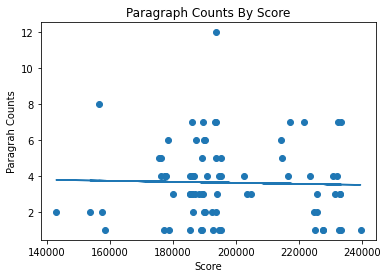

R value for Paragraph Counts is -0.028673351879075007


In [ ]:
#Check if amount of paragraph term usage is indicative of grade
#Based on results (r = .08, there is little relationship between amount of rhetorical terms used and grade...at least between A and B range essays)
from scipy import stats

#Check if amount of usages of pathos is indicative of grade
#Based on results (r = .08, there is little relationship between amount of rhetorical terms used and grade...at least between A and B range essays)

#Create arrays of independent (x) and dependent (y) variables
x = np.array(df3['Score'])
y = np.array(df3['Paragraph_Counts'])

#Return key values of linear regression
slope, intercept, r, p, std_err = stats.linregress(x, y)

#Create function to return new equation
def myfunc(x):
  return slope * x + intercept

mymodel = list(map(myfunc, x))

plt.scatter(x, y)
plt.plot(x, mymodel)
plt.title("Paragraph Counts By Score")
plt.xlabel("Score")
plt.ylabel("Paragrah Counts")
plt.show()

print("R value for Paragraph Counts is " + str(r))

In [ ]:
rhetorical_keywords_df_no_blanks.Text

119      Orso’s Street Harassment in Philly talks about...
123              \t Orso uses the rhetorical element pa...
125              \tOrso also uses stories from women to...
127              \tOrso use of statistics within logos ...
262      In the first rhetorical analysis essay it brou...
                               ...                        
15888    Anna Orso, fellow Penn State student journalis...
15966    Orso’s use of anecdotes heightens the reader’s...
15972    Quantifying data and numerical evidence create...
15973    By writing the article heavily saturated in pe...
15975    into pathos. With each different anecdote, the...
Name: Text, Length: 283, dtype: object

In [ ]:
#Get positionality of each term in text
search_str = 'pathos'
results = []

for text in rhetorical_keywords_df_no_blanks.Text:
  result = [i+1 for i,w in enumerate(text.split()) if w == search_str]
  results.append(result)

rhetorical_keywords_df_no_blanks['Pathos_Positions'] = results


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
rhetorical_keywords_df_no_blanks

,ID_Score,Paragraph,Text,Pathos_Counts,Ethos_Counts,Logos_Counts,Sum_Terms,Pathos_Positions
119,73.0_202621,8,Orso’s Street Harassment in Philly talks about...,1,0,1,2,[75]
123,73.0_202621,12,\t Orso uses the rhetorical element pa...,1,0,0,1,[6]
125,73.0_202621,14,\tOrso also uses stories from women to...,1,0,0,1,[]
127,73.0_202621,16,\tOrso use of statistics within logos ...,0,0,1,1,[]
262,76.0_158545,21,In the first rhetorical analysis essay it brou...,1,0,0,1,[25]
...,...,...,...,...,...,...,...,...
15888,96.0_225111,14,"Anna Orso, fellow Penn State student journalis...",10,0,0,10,"[53, 209, 307, 1026, 1454, 1542, 1570, 1595]"
15966,97.0_230811,9,Orso’s use of anecdotes heightens the reader’s...,2,0,0,2,[303]
15972,97.0_230811,15,Quantifying data and numerical evidence create...,0,0,2,2,[]
15973,97.0_230811,16,By writing the article heavily saturated in pe...,0,0,1,1,[]
